In [2]:
import warnings
warnings.filterwarnings("ignore")

# Text

In [ ]:
from transformers import pipeline

# classifier = pipeline("sentiment-analysis")
# classifier("I've been waiting for a HuggingFace course my whole life.")

In [ ]:
classifier = pipeline("sentiment-analysis")

In [ ]:
classifier("I've been waiting for a HuggingFace course my whole life.")

In [ ]:
classifier = pipeline("sentiment-analysis")
classifier("My flight on American has been okay today, albeit early and slightly bumpy.")

In [ ]:
from transformers import pipeline

classifier = pipeline("zero-shot-classification")
classifier(
    "This is a course about the Transformers library",
    candidate_labels=["education", "politics", "business"],
)

In [ ]:
from transformers import pipeline

ner = pipeline("ner", grouped_entities=True)
ner("My name is Sylvain and I work at Hugging Face in Brooklyn.")

In [ ]:
ner("My name is Albert and I'm teaching at Seminole State College of Florida in Sanford, FL.")

In [ ]:
from transformers import pipeline

classifier = pipeline("zero-shot-classification")
classifier(
    "This is a course about the Transformers library",
    candidate_labels=["education", "politics", "business"],
)

In [ ]:
from transformers import pipeline

ner = pipeline("ner", grouped_entities=True)
ner("My name is Sylvain and I work at Hugging Face in Brooklyn.")

In [3]:
from transformers import pipeline

summarizer = pipeline("summarization")
summarizer(
    """
    America has changed dramatically during recent years. Not only has the number of 
    graduates in traditional engineering disciplines such as mechanical, civil, 
    electrical, chemical, and aeronautical engineering declined, but in most of 
    the premier American universities engineering curricula now concentrate on 
    and encourage largely the study of engineering science. As a result, there 
    are declining offerings in engineering subjects dealing with infrastructure, 
    the environment, and related issues, and greater concentration on high 
    technology subjects, largely supporting increasingly complex scientific 
    developments. While the latter is important, it should not be at the expense 
    of more traditional engineering.

    Rapidly developing economies such as China and India, as well as other 
    industrial countries in Europe and Asia, continue to encourage and advance 
    the teaching of engineering. Both China and India, respectively, graduate 
    six and eight times as many traditional engineers as does the United States. 
    Other industrial countries at minimum maintain their output, while America 
    suffers an increasingly serious decline in the number of engineering graduates 
    and a lack of well-educated engineers.
"""
)

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'summary_text': ' America has changed dramatically during recent years . The number of engineering graduates in the U.S. has declined in traditional engineering disciplines such as mechanical, civil,    electrical, chemical, and aeronautical engineering . Rapidly developing economies such as China and India continue to encourage and advance the teaching of engineering .'}]

# Audio

In [115]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset, Audio
import gradio as gr
from transformers import WhisperFeatureExtractor
import regex as re
import pandas as pd

In [4]:
array, sampling_rate = librosa.load(librosa.ex("trumpet"))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


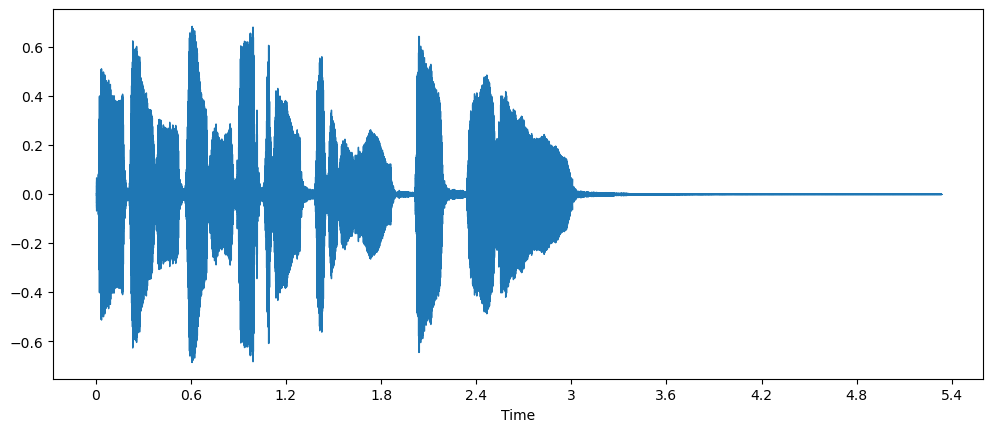

In [7]:
# import librosa.display

plt.figure().set_figwidth(12)
librosa.display.waveshow(array, sr=sampling_rate)

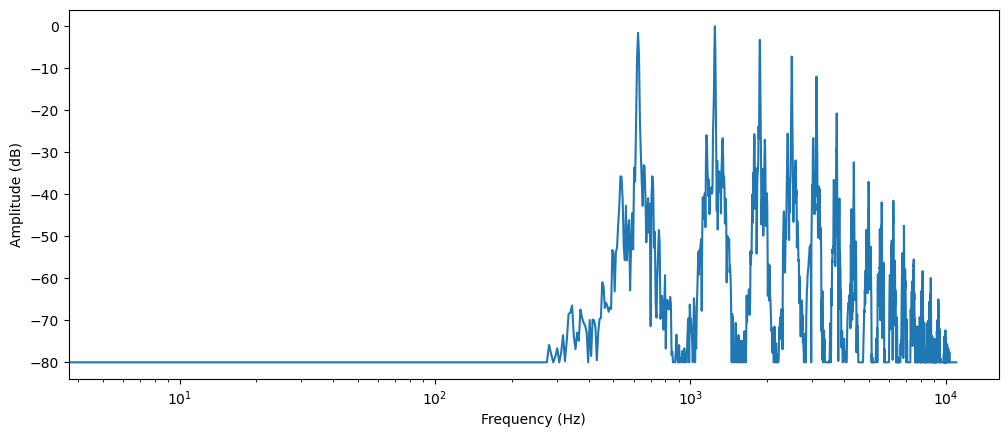

In [10]:
dft_input = array[:4096]

# calculate the DFT
window = np.hanning(len(dft_input))
windowed_input = dft_input * window
# Hugging Face calls this a discreet Fourier transform, but it's really a fast Fourier transform; apparently
# it's computationally impractical to do discreet.
dft = np.fft.rfft(windowed_input)

# get the amplitude spectrum in decibels
amplitude = np.abs(dft)
amplitude_db = librosa.amplitude_to_db(amplitude, ref=np.max)

# get the frequency bins
frequency = librosa.fft_frequencies(sr=sampling_rate, n_fft=len(dft_input))

plt.figure().set_figwidth(12)
plt.plot(frequency, amplitude_db)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.xscale("log")

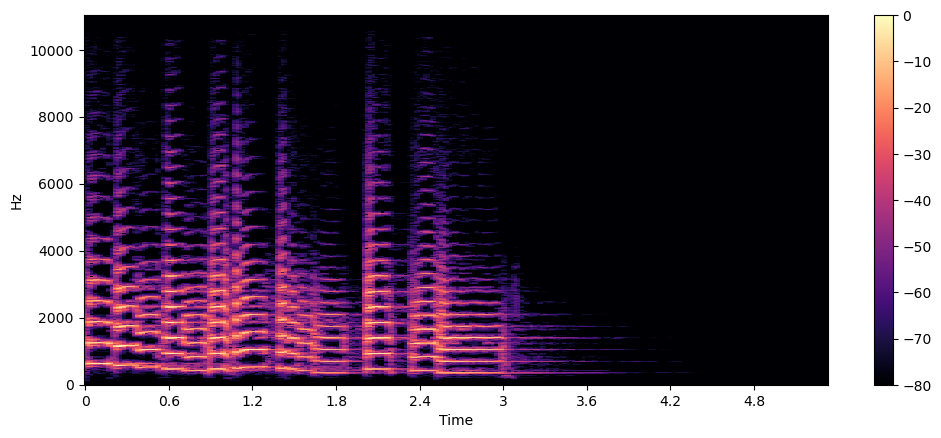

In [11]:
# performs a Short Time Fourier Transform to plot time, frequency, amplitude

D = librosa.stft(array)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_db, x_axis="time", y_axis="hz")
plt.colorbar()

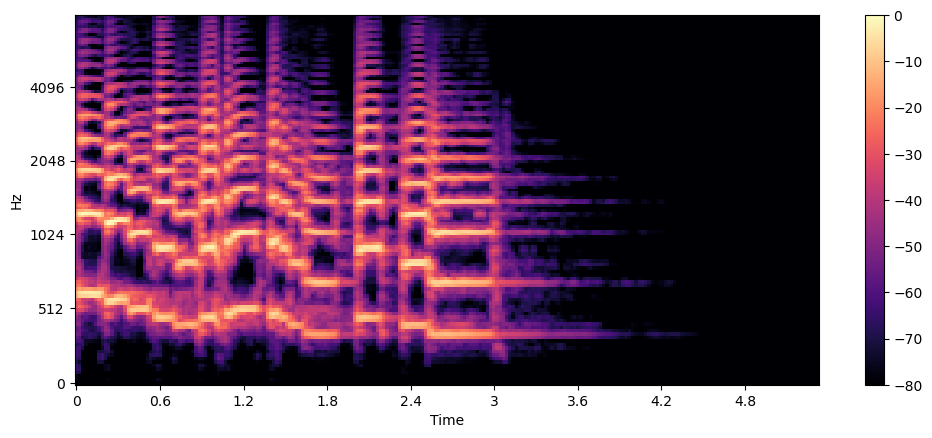

In [12]:
# the mel spectrogram uses a nonlinear frequency scale approximating human hearing

S = librosa.feature.melspectrogram(y=array, sr=sampling_rate, n_mels=128, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_dB, x_axis="time", y_axis="mel", sr=sampling_rate, fmax=8000)
plt.colorbar()

In [45]:
minds = load_dataset("PolyAI/minds14", name="en-AU", split="train")
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 654
})

In [47]:
example = minds[0]
example

{'path': '/Users/albert/.cache/huggingface/datasets/downloads/extracted/085a7704b63dbeff7d03c75739f4c1fbcc579877ae4a722ef85a5b10bd5dcfd7/en-AU~PAY_BILL/response_4.wav',
 'audio': {'path': '/Users/albert/.cache/huggingface/datasets/downloads/extracted/085a7704b63dbeff7d03c75739f4c1fbcc579877ae4a722ef85a5b10bd5dcfd7/en-AU~PAY_BILL/response_4.wav',
  'array': array([ 0.        ,  0.00024414, -0.00024414, ..., -0.00024414,
          0.00024414,  0.0012207 ]),
  'sampling_rate': 8000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'english_transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13,
 'lang_id': 2}

In [48]:
id2label = minds.features["intent_class"].int2str
id2label(example["intent_class"])

'pay_bill'

In [49]:
columns_to_remove = ["lang_id", "english_transcription"]
minds = minds.remove_columns(columns_to_remove)
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 654
})

In [50]:
def generate_audio():
    example = minds.shuffle()[0]
    audio = example["audio"]
    return (
        audio["sampling_rate"],
        audio["array"],
    ), id2label(example["intent_class"])


with gr.Blocks() as demo:
    with gr.Column():
        for _ in range(4):
            audio, label = generate_audio()
            output = gr.Audio(audio, label=label)

demo.launch(debug=True)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.


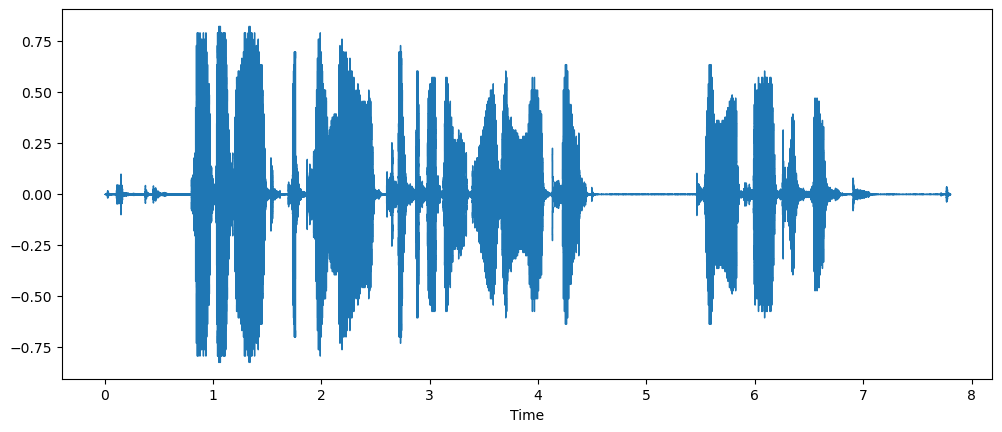

In [51]:
# example = minds[1]
array = example["audio"]["array"]
sampling_rate = example["audio"]["sampling_rate"]

plt.figure().set_figwidth(12)
librosa.display.waveshow(array, sr=sampling_rate)

In [53]:
minds = minds.cast_column("audio", Audio(sampling_rate=16_000))
minds[0]

{'path': '/Users/albert/.cache/huggingface/datasets/downloads/extracted/085a7704b63dbeff7d03c75739f4c1fbcc579877ae4a722ef85a5b10bd5dcfd7/en-AU~PAY_BILL/response_4.wav',
 'audio': {'path': '/Users/albert/.cache/huggingface/datasets/downloads/extracted/085a7704b63dbeff7d03c75739f4c1fbcc579877ae4a722ef85a5b10bd5dcfd7/en-AU~PAY_BILL/response_4.wav',
  'array': array([2.36111518e-05, 1.92324907e-04, 2.19284615e-04, ...,
         9.40906350e-04, 1.16613042e-03, 7.20882323e-04]),
  'sampling_rate': 16000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13}

In [55]:
display(minds)

MAX_DURATION_IN_SECONDS = 20.0

def is_audio_length_in_range(input_length):
    return input_length < MAX_DURATION_IN_SECONDS

# use librosa to get example's duration from the audio file
new_column = [librosa.get_duration(path=x) for x in minds["path"]]
minds = minds.add_column("duration", new_column)

# use 🤗 Datasets' `filter` method to apply the filtering function
minds = minds.filter(is_audio_length_in_range, input_columns=["duration"])

# remove the temporary helper column
minds = minds.remove_columns(["duration"])

display(minds)

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 654
})

Filter:   0%|          | 0/654 [00:00<?, ? examples/s]

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 624
})

In [57]:
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")

def prepare_dataset(example):
    audio = example["audio"]
    features = feature_extractor(
        audio["array"], sampling_rate=audio["sampling_rate"], padding=True
    )
    return features

minds = minds.map(prepare_dataset)
minds

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

Map:   0%|          | 0/624 [00:00<?, ? examples/s]

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class', 'input_features'],
    num_rows: 624
})

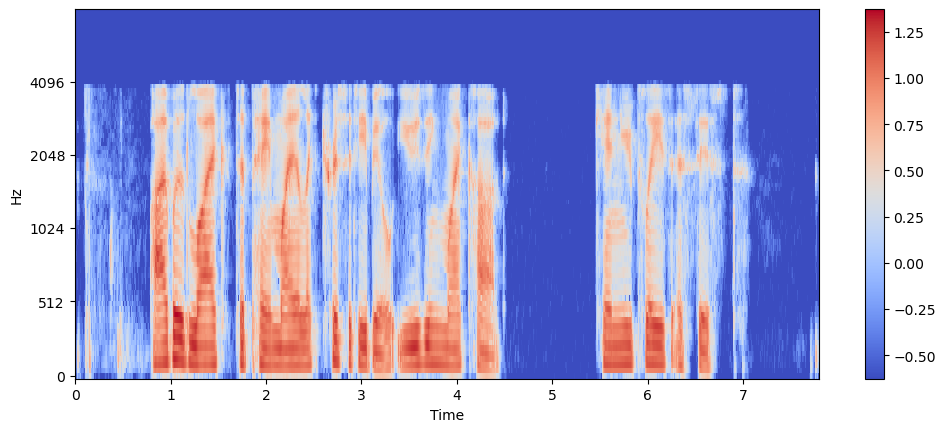

In [58]:
example = minds[0]
input_features = example["input_features"]

plt.figure().set_figwidth(12)
librosa.display.specshow(
    np.asarray(input_features[0]),
    x_axis="time",
    y_axis="mel",
    sr=feature_extractor.sampling_rate,
    hop_length=feature_extractor.hop_length,
)
plt.colorbar()

In [ ]:
#### for large data sets can stream them ie below. can iterate to get an example, or multiple examples

# gigaspeech = load_dataset("speechcolab/gigaspeech", "xs", streaming=True)

# next(iter(gigaspeech["train"]))

# gigaspeech_head = gigaspeech["train"].take(2)
# list(gigaspeech_head)

In [88]:
minds = load_dataset("PolyAI/minds14", name="en-AU", split="train")
minds = minds.cast_column("audio", Audio(sampling_rate=16_000))

classifier = pipeline(
    "audio-classification",
    model="anton-l/xtreme_s_xlsr_300m_minds14",
)

example = minds[0]
classifier(example["audio"]["array"])

[{'score': 0.9625311493873596, 'label': 'pay_bill'},
 {'score': 0.028672710061073303, 'label': 'freeze'},
 {'score': 0.003349797800183296, 'label': 'card_issues'},
 {'score': 0.0020058038644492626, 'label': 'abroad'},
 {'score': 0.000848432828206569, 'label': 'high_value_payment'}]

In [91]:
asr = pipeline("automatic-speech-recognition")
example = minds[0]
asr(example["audio"]["array"])

No model was supplied, defaulted to facebook/wav2vec2-base-960h and revision 55bb623 (https://huggingface.co/facebook/wav2vec2-base-960h).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'text': 'I WOULD LIKE TO PAY MY ELECTRICITY BILL USING MY CAD CAN YOU PLEASE ASSIST'}

In [61]:
example["english_transcription"]

'I would like to pay my electricity bill using my card can you please assist'

In [62]:
minds = load_dataset("PolyAI/minds14", name="de-DE", split="train")
minds = minds.cast_column("audio", Audio(sampling_rate=16_000))
example = minds[0]
example["transcription"]

'ich möchte gerne Geld auf mein Konto einzahlen'

In [63]:
asr = pipeline("automatic-speech-recognition", model="maxidl/wav2vec2-large-xlsr-german")
asr(example["audio"]["array"])

config.json:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/158 [00:00<?, ?B/s]

{'text': 'ich möchte gerne geld auf mein konto einzallen'}

In [81]:
from IPython.display import Audio as ip_audio

In [82]:
pipe = pipeline("text-to-speech", model="suno/bark-small")

text = "Ladybugs have had important roles in culture and religion, being associated with luck, love, fertility and prophecy. "
output = pipe(text)

ip_audio(output["audio"], rate=output["sampling_rate"])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:10000 for open-end generation.


In [83]:
fr_text = "Contrairement à une idée répandue, le nombre de points sur les élytres d'une coccinelle ne correspond pas à son âge, ni en nombre d'années, ni en nombre de mois. "
output = pipe(fr_text)
ip_audio(output["audio"], rate=output["sampling_rate"])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:10000 for open-end generation.


In [ ]:
song = "♪ In the jungle, the mighty jungle, the ladybug was seen. ♪ "
output = pipe(song)
ip_audio(output["audio"], rate=output["sampling_rate"])

In [ ]:
music_pipe = pipeline("text-to-audio", model="facebook/musicgen-small")
text = "90s rock song with electric guitar and heavy drums"
forward_params = {"max_new_tokens": 512}

output = music_pipe(text, forward_params=forward_params)
Audio(output["audio"][0], rate=output["sampling_rate"])

# me playing

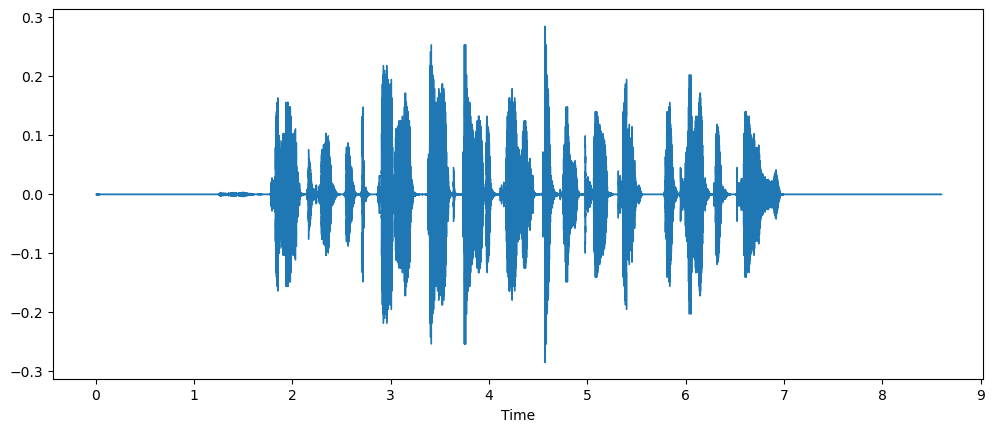

In [43]:
minds = load_dataset("PolyAI/minds14", name="de-DE", split="train")
example = minds[2]
id2label = minds.features["intent_class"].int2str
id2label(example["intent_class"])
array = example["audio"]["array"]
sampling_rate = example["audio"]["sampling_rate"]
plt.figure().set_figwidth(12)
librosa.display.waveshow(array, sr=sampling_rate)

In [44]:
example

{'path': '/Users/albert/.cache/huggingface/datasets/downloads/extracted/085a7704b63dbeff7d03c75739f4c1fbcc579877ae4a722ef85a5b10bd5dcfd7/de-DE~CASH_DEPOSIT/CAd15a78e174ea14ae25901c429ce44e40_0.wav',
 'audio': {'path': '/Users/albert/.cache/huggingface/datasets/downloads/extracted/085a7704b63dbeff7d03c75739f4c1fbcc579877ae4a722ef85a5b10bd5dcfd7/de-DE~CASH_DEPOSIT/CAd15a78e174ea14ae25901c429ce44e40_0.wav',
  'array': array([-0.00024414, -0.00024414, -0.00048828, ...,  0.00024414,
          0.00024414,  0.00024414]),
  'sampling_rate': 8000},
 'transcription': 'Hallo ich möchte gerne Geld einbezahlen auf mein Konto wie kann ich das tun',
 'english_transcription': 'Hello I would like to deposit money into my account how can I do that',
 'intent_class': 7,
 'lang_id': 1}

In [40]:
with gr.Blocks() as demo:
    audio = example["audio"]
    gr.Audio((audio["sampling_rate"], audio["array"],), label = id2label(example["intent_class"]))
demo.launch(debug=True)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.


In [92]:
array, sampling_rate = librosa.load("./data/audio_test.m4a")

plt.figure().set_figwidth(12)
librosa.display.waveshow(array, sr=sampling_rate)

with gr.Blocks() as demo:
    audio = array
    gr.Audio((sampling_rate, array,), label = "test file")
demo.launch(debug=True)

In [86]:
array, sampling_rate = librosa.load("./data/audio_test.m4a")
asr = pipeline("automatic-speech-recognition", model="openai/whisper-large-v3")
asr(array)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


{'text': ' Oh, this is a test to see if this will understand audio, especially numbers 1, 2, 3, 4.5, 9, 4, 1, and if it will understand pauses and breaks in conversation.'}

In [93]:
array, sampling_rate = librosa.load("./data/audio_test.m4a")
asr = pipeline("automatic-speech-recognition", model="facebook/wav2vec2-base-960h")
asr(array)

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'text': 'OH THIS IS A TEST TO SEE IF THIS WILL UNDERSTAND AUDIOE ESPECIALLY NUMBERS ONE TWO THREE FOUR POINT FIVE NINE FOUR ONE AND IF YOU ALL UNDERSTAND PAUSES AND BREAKS IN CONVERSATION'}

Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.

In [95]:
array, sampling_rate = librosa.load("./data/grades.m4a")
asr = pipeline("automatic-speech-recognition", model = "openai/whisper-large-v3")
# asr = pipeline("automatic-speech-recognition", model="facebook/wav2vec2-base-960h")
result = asr(array)
result

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


{'text': ' Alpha 10 4 1.5 6 6 6 3 1 3 2 0 5 4 3 2 4 4 8 Beta 530. Beta 530. 5, 5, 4, 2, 2, 2, 6, 2, 7. 412 428 110'}

In [103]:
array, sampling_rate = librosa.load("./data/grades.m4a")
# asr = pipeline("automatic-speech-recognition", model = "openai/whisper-tiny.en")
asr = pipeline("automatic-speech-recognition", model = "openai/whisper-base.en")
# asr = pipeline("automatic-speech-recognition", model = "openai/whisper-large-v3")
# asr = pipeline("automatic-speech-recognition", model="facebook/wav2vec2-base-960h")
result = asr(array, chunk_length_s=30, batch_size=8,)
result

{'text': ' Alpha 10, 4. 10.5. 6, 6, 6, 3, 1, 3, 2, 0, 5, 4, 3, 2, 4 4 8 2 3 0 Beta 5 3 0 5 5 4 2 2 2 6 2 7 4 1 2 4 2 8 1 1 0'}

In [113]:
result['text']

str

In [112]:
outcome = re.findall(r'\d+', result['text'])

for x in range(0,len(outcome)):
    outcome[x] = int(outcome[x])
sum(outcome)

157

In [114]:
input_str = result['text']

pattern = r"(\w+)((?:[\s\d.,]+)+)"

# Find all matches in the input string
matches = re.findall(pattern, input_str)

# Initialize the dictionary
result = {}

# Iterate through matches and populate the dictionary
for match in matches:
    name = match[0]
    numbers = re.findall(r"[-+]?\d*\.\d+|\d+", match[1])
    result[name] = [float(num) if '.' in num else int(num) for num in numbers]

# Print the result
print(result)

{'Alpha': [10, 4, 10.5, 6, 6, 6, 3, 1, 3, 2, 0, 5, 4, 3, 2, 4, 4, 8, 2, 3, 0], 'Beta': [5, 3, 0, 5, 5, 4, 2, 2, 2, 6, 2, 7, 4, 1, 2, 4, 2, 8, 1, 1, 0]}


In [124]:
df = pd.DataFrame(result).T
df['total'] = df.sum(axis=1)
df

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,total
Alpha,10.0,4.0,10.5,6.0,6.0,6.0,3.0,1.0,3.0,2.0,...,4.0,3.0,2.0,4.0,4.0,8.0,2.0,3.0,0.0,86.5
Beta,5.0,3.0,0.0,5.0,5.0,4.0,2.0,2.0,2.0,6.0,...,4.0,1.0,2.0,4.0,2.0,8.0,1.0,1.0,0.0,66.0


In [ ]:
import torch
from transformers import pipeline

device = "cuda:0" if torch.cuda.is_available() else "cpu"